In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from kan import KAN
device = "cuda"

In [11]:
def true_solution(t):
    return torch.exp(-t)

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 3),
            nn.Tanh(),
            nn.Linear(3, 3),
            nn.Tanh(),
            nn.Linear(3, 1)
        )

    def forward(self, x):
        return self.net(x)

class KANWrapper(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = KAN(width=[1,3,3,1], grid=3, k=3, seed=42)

    def forward(self, x):
        return self.net(x)


In [22]:

def pinn_loss(model, t_domain, initial_point):
    t_domain.requires_grad_(True)
    y_pred = model(t_domain)

    dy_dt = torch.autograd.grad(y_pred.sum(), t_domain, create_graph=True)[0]

    eq_loss = torch.mean((dy_dt + y_pred)**2)
    ic_loss = (model(initial_point) - 1.0)**2
    return eq_loss + ic_loss

In [ ]:

# Подготовка данных
t = torch.linspace(0, 5, 100).reshape(-1, 1)
initial_point = torch.tensor([[0.0]])

# Обучение MLP
mlp_model = MLP()
mlp_optimizer = torch.optim.Adam(mlp_model.parameters(), lr=0.001)

epoch_num = 2500
epoch_print_interval = 200

print("Training MLP model...")
for epoch in range(epoch_num):
    mlp_optimizer.zero_grad()
    loss = pinn_loss(mlp_model, t, initial_point)
    loss.backward()
    mlp_optimizer.step()
    if epoch % epoch_print_interval == 0:
        print(f'MLP Epoch {epoch}, Loss: {loss.item():.6f}')

# Обучение KAN
kan_model = KANWrapper()
kan_optimizer = torch.optim.Adam(kan_model.parameters(), lr=0.001)

print("\nTraining KAN model...")
for epoch in range(epoch_num):
    kan_optimizer.zero_grad()
    loss = pinn_loss(kan_model, t, initial_point)
    loss.backward()
    kan_optimizer.step()
    if epoch % epoch_print_interval == 0:
        print(f'KAN Epoch {epoch}, Loss: {loss.item():.6f}')

# Визуализация результатов
t_numpy = t.detach().cpu().numpy()
y_true = true_solution(t).detach().cpu().numpy()
y_mlp = mlp_model(t).detach().cpu().numpy()
y_kan = kan_model(t).detach().cpu().numpy()

plt.figure(figsize=(10, 6))
plt.plot(t_numpy, y_true, 'b-', label='True Solution')
plt.plot(t_numpy, y_mlp, 'r--', label='MLP Solution')
plt.plot(t_numpy, y_kan, 'g--', label='KAN Solution')
plt.legend()
plt.xlabel('t')
plt.ylabel('y')
plt.title('Comparison of Solutions: y\' = -y, y(0) = 1')
plt.grid(True)
plt.show()

Training MLP model...
MLP Epoch 0, Loss: 0.215121
MLP Epoch 200, Loss: 0.018174
MLP Epoch 400, Loss: 0.006078
MLP Epoch 600, Loss: 0.002635
MLP Epoch 800, Loss: 0.001256
MLP Epoch 1000, Loss: 0.000621
MLP Epoch 1200, Loss: 0.000323
MLP Epoch 1400, Loss: 0.000187
MLP Epoch 1600, Loss: 0.000123
MLP Epoch 1800, Loss: 0.000089
MLP Epoch 2000, Loss: 0.000070
MLP Epoch 2200, Loss: 0.000057
MLP Epoch 2400, Loss: 0.000049
checkpoint directory created: ./model
saving model version 0.0

Training KAN model...
KAN Epoch 0, Loss: 1.153420
KAN Epoch 200, Loss: 0.037632
KAN Epoch 400, Loss: 0.001827
KAN Epoch 600, Loss: 0.000552
KAN Epoch 800, Loss: 0.000237
KAN Epoch 1000, Loss: 0.000114
KAN Epoch 1200, Loss: 0.000067
KAN Epoch 1400, Loss: 0.000046


In [18]:

# Вычисление ошибок
mlp_error = np.mean((y_true - y_mlp)**2)
kan_error = np.mean((y_true - y_kan)**2)
print(f'MLP MSE: {mlp_error:.6f}')
print(f'KAN MSE: {kan_error:.6f}')

# Проверка точности удовлетворения дифференциального уравнения
t_test = torch.linspace(0, 5, 1000).reshape(-1, 1)
t_test.requires_grad_(True)

# Проверка для MLP
y_mlp_test = mlp_model(t_test)
dy_dt_mlp = torch.autograd.grad(y_mlp_test.sum(), t_test, create_graph=True)[0]
eq_error_mlp = torch.mean((dy_dt_mlp + y_mlp_test)**2).item()

# Проверка для KAN
y_kan_test = kan_model(t_test)
dy_dt_kan = torch.autograd.grad(y_kan_test.sum(), t_test, create_graph=True)[0]
eq_error_kan = torch.mean((dy_dt_kan + y_kan_test)**2).item()

print(f'\nDifferential equation error (MLP): {eq_error_mlp:.6f}')
print(f'Differential equation error (KAN): {eq_error_kan:.6f}')

MLP MSE: 0.000003
KAN MSE: 0.000000

Differential equation error (MLP): 0.000035
Differential equation error (KAN): 0.000009


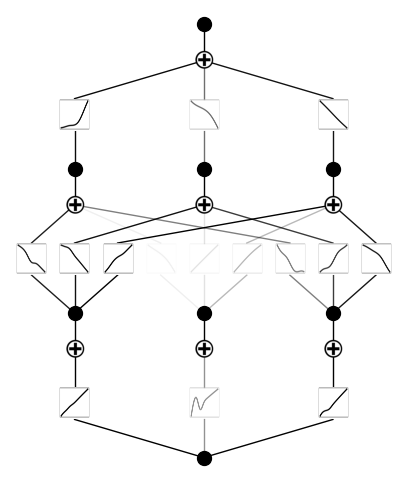

In [20]:
kan_model.net.plot()